# 变分量子奇异值分解


## 概述

文章[1]中提出了一种新的对矩阵进行奇异值分解的变分量子算法（VQSVD)。利用变分原理和Ky Fand定理，文章作者设计了一个新的损失函数（loss function)。通过该损失函数，我们可以训练两个量子神经网络，从而得到矩阵的奇异值和奇异矢量。文中作者通过实例来验证了他们算法的有效性，并将其运用到压缩图片上，此外，作者还讨论了该算法在推荐系统和极分解中的应用。 相比于其他量子奇异值分解算法，VQSVD可应用于非厄密(non-Hermitian)数据，并且需要更少的量子计算资源，可以在近期可实现的噪声中型量子设备(NISQ)上运行。在NISQ时代，作为对哈密顿量对角化（或谱分解）的变分量子本征求解算法的一种推广，VQSVD算法在量子化学、量子机器学习和量子优化方面具有潜在应用。

## 算法简介
该算法的目的是实现矩阵的奇异值分解，即对于给定的$n \times m$维复矩阵$M$，将其分解为$M=UDV^{\dagger}$的形式，其中$U$为$m \times m$维酉矩阵，$D$为$m \times n$维对角矩阵，其对角元为非负实数，$V$为$n \times n$维酉矩阵。当$M$为实矩阵时，$U$和$V$为实正交矩阵。

该VQSVD算法分为以下几步：

1.对于给定的秩(rank)为$T$的矩阵$M$,首先将其分解为$K$个酉矩阵的线性叠加$M=\sum_{k=1}^K c_k A_k$，其中$c_k$为实数，$A_k$为酉矩阵;

2.准备$T$个正数$q_1 >  \cdots > q_T>0$以用来计算损失函数，并设定损失函数（Loss function）的容许偏差为$\epsilon$;

3.准备含参数的量子电路$U({\bf \alpha})$和$V({\bf \beta})$，并设定${\bf \alpha}$和${\bf \beta}$的初始值;

4.选择一组计算基:$|\psi_1 \rangle$，$\cdots$，$|\psi_T \rangle$;

5.对$j=1,\cdots, T$进行如下循环：
     计算$|u_j \rangle = U({\bf \alpha})|\psi_j \rangle $，$|v_j \rangle = V({\bf \beta})|\psi_j \rangle $，并通过Hadamard测试来计算$m_j = Re \langle u_j | M | v_j$;
     
6.得到所有$m_j, j=1,\cdots, T$后，计算损失函数$L({\bf \alpha},{\bf \beta}) = \sum_{j=1}^T q_j m_j$;

7.利用最优化算法来使损失函数$L({\bf \alpha},{\bf \beta})$最大化，并更新参数${\bf \alpha},{\bf \beta}$；

8.重复上述步骤5-7直至$L({\bf \alpha},{\bf \beta})$收敛到容许偏差小于$\epsilon$;

9.输出$\{m_j\}_{j=1}^T$,对应矩阵$M$最大的$T$个奇异值，并且输出$U({\bf \alpha^*})$和$V({\bf \beta^*})$，得到左奇异矢为$(\langle \psi_j | U({\bf \alpha^*}))^{\dagger}$,右奇异矢为$V({\bf \beta^*}) | \psi_j \rangle$。

步骤7中用来使损失函数$L({\bf \alpha},{\bf \beta})$最大化的算法可以采用gradient-based或gradient-free方法。文中作者证明了如下关系
$$ \frac{\partial L}{\partial \alpha_l} = \frac{L({\bf \alpha'},{\bf \beta})}{2}, \text{where} \;{\bf \alpha'} = (\alpha_1, \ldots, \alpha_l+\pi, \ldots,\alpha_{l_1}),$$
$$ \frac{\partial L}{\partial \beta_k} = \frac{L({\bf \alpha},{\bf \beta'})}{2}, \text{where} \;{\bf \beta'} = (\beta_1, \ldots, \beta_k-\pi, \ldots,\beta_{l_2})。$$
下面的算法实现中，我将基于此关系采用gradient-based方法来对$L({\bf \alpha},{\bf \beta})$进行优化。

以下为论文[1]中提供的该算法的原理图![title](image/vqsvd_schematic.png)

## 算法实现

以下我们将逐步实现此VQSVD算法。

### 1.准备输入矩阵$M$并将其分解为一系列酉矩阵的求和 $M=\sum_{k=1}^K c_k A_k$

将任意矩阵$M$分解为一系列酉矩阵的求和涉及到额外的算法设计，简单起见，这里我设$K=3$,并且设计三个量子电路（对应$A_k, k=1,\ldots, K$),然后产生$K$个随机数作为$c_k, k=1,\ldots, K$。

In [2]:
import numpy as np
import scipy.linalg
import math
from mindquantum.core.gates import RX, RY, RZ, X, H   # 导入量子门 X, RY
from mindquantum.core.circuit import shift, Circuit, add_prefix, add_suffix

PI = math.pi

In [3]:
A0_circ = Circuit()                              # 初始化量子线路
A0_circ = RZ(PI/7).on(0) + Circuit([X.on(1, 0)]) + RY(PI/3).on(1) + Circuit([X.on(2, 1)]) + RX(PI/2).on(2)
A0 = A0_circ.matrix()

A1_circ = Circuit()                              # 初始化量子线路
A1_circ = RX(PI/6).on(0) + Circuit([X.on(1, 0)]) + H.on(1) + Circuit([X.on(1, 2)]) + RY(2*PI/3).on(2)
A1=A1_circ.matrix()
A0_circ.svg()

A2_circ = Circuit()                              # 初始化量子线路
A2_circ = RX(PI/4).on(0) + Circuit([X.on(1, 0)]) + RX(PI/3).on(2) + Circuit([X.on(2, 1)])
A2=A2_circ.matrix()
np.allclose(np.eye(len(A2)), A2.dot(A2.T.conj()))

K=3                                      #set K=3
ck=np.random.random(K)                   #generate c_k
print("ck=\n",ck)
M=ck[0]*A0+ck[1]*A1+ck[2]*A2             #generate M

#M=np.random.random((n, n))+1j*np.random.random((n, n))
T=np.linalg.matrix_rank(M)              # rank of M
#print("M=\n",M)
print("rank of M is", T)
U, D, Vh = np.linalg.svd(M, full_matrices=True)   # find the SVD results using classial method
#print("U=\n",U,"\n","D=\n",D,"\n","Vh=\n",Vh)
#np.allclose(M, np.matmul(np.matmul(U,np.diag(D)), Vh))                     #check

ck=
 [0.8387989  0.36381104 0.79942481]
rank of M is 8


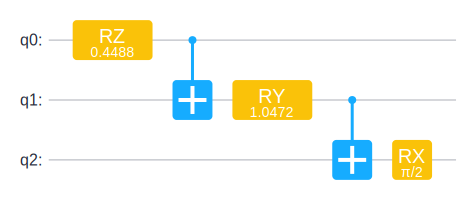

In [7]:
A0_circ.svg()

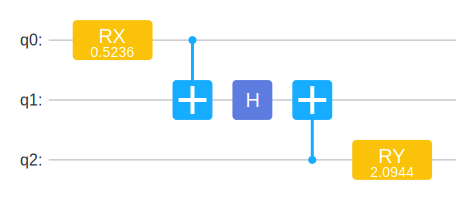

In [8]:
A1_circ.svg()

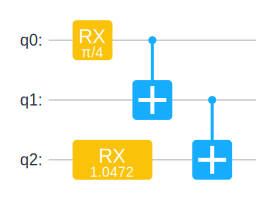

In [9]:
A2_circ.svg()

### 2.准备$T$个正数$q_1 >  \cdots > q_T>0$以用来计算损失函数，并设定损失函数（Loss function）的容许偏差为$\epsilon$

遵从论文[1]中的3-qubit示例，这里我们设$(q_1,\ldots,q_T)=(T, T-1, \cdots, 1)$。

In [10]:
q_array = np.arange(T,0,-1)   #set q
tol = 1e-4                    #set tolerance

### 3.准备含参数的量子电路$U({\bf \alpha})$和$V({\bf \beta})$，并设定${\bf \alpha}$和${\bf \beta}$的初始值


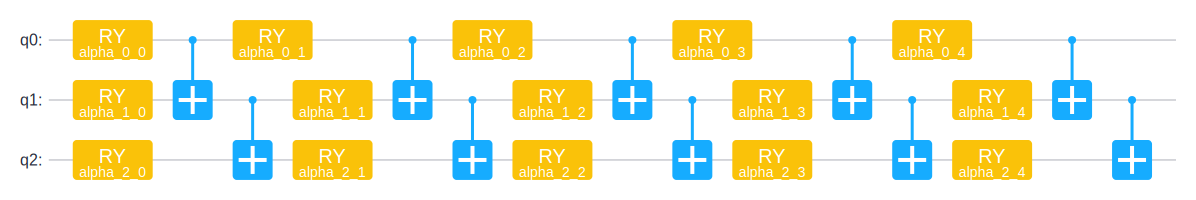

In [16]:
# parameterized circuits U and V
Depth=5   #Depth
N=3       #N qubits for U
alpha0 = np.full((N, Depth), PI/3) #initial values of \alpha_i,j
beta0 = np.full((N, Depth), PI/3)  #initial values of \beta_i,j
U_circ = Circuit() 
template0 = Circuit([X.on(1, 0)])
templateU = (RY(f'alpha_{i}').on(i) for i in range(N)) + sum( shift(template0, i) for i in range(N-1))
U_circ = sum( add_suffix(templateU,f'{i}') for i in range(Depth))
U_circ.svg()

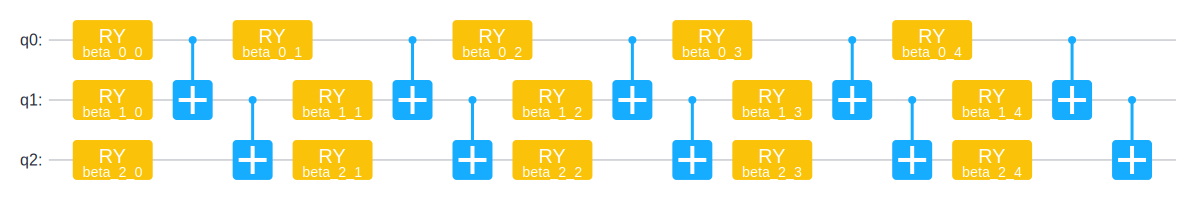

In [17]:
V_circ = Circuit()                              # 初始化量子线路
templateV = (RY(f'beta_{i}').on(i) for i in range(N)) + sum( shift(template0, i) for i in range(N-1))
V_circ = sum( add_suffix(templateV,f'{i}') for i in range(Depth))
V_circ.svg()

### 4.选择一组计算基:$|\psi_1 \rangle$，$\cdots$，$|\psi_T \rangle$


In [18]:
#https://github.com/learner-long-life/skc-python/tree/master
# Get the standard vector basis for R^n, that is, n n-dimensional vectors
# { v[i] } where v[i] has a 1 in the ith component and 0 everywhere else
def get_standard_vector_basis(d):

	# Get standard basis orthonormal basis vectors for Z_d
	# v[i] will have 1 in the ith component, zero everywhere else
	v = []
	for i in range(d):
		new_vec = np.zeros(d)
		# Set one of the components to be 1, the rest stay zeros
		new_vec[i] = 1
		v.append(new_vec)
		#print "v["+str(i)+"]= " + str(new_vec)
	return v

psi = get_standard_vector_basis(2**N)

### 5-8
5.对$j=1,\cdots, T$进行如下循环：
     计算$|u_j \rangle = U({\bf \alpha})|\psi_j \rangle $，$|v_j \rangle = V({\bf \beta})|\psi_j \rangle $，并通过Hadamard测试来计算$m_j = Re \langle u_j | M | v_j$;
     
6.得到所有$m_j, j=1,\cdots, T$后，计算损失函数$L({\bf \alpha},{\bf \beta}) = \sum_{j=1}^T q_j m_j$;

7.利用最优化算法来使损失函数$L({\bf \alpha},{\bf \beta})$最大化，并更新参数${\bf \alpha},{\bf \beta}$；

8.重复上述步骤5-7直至$L({\bf \alpha},{\bf \beta})$收敛到容许偏差小于$\epsilon$;


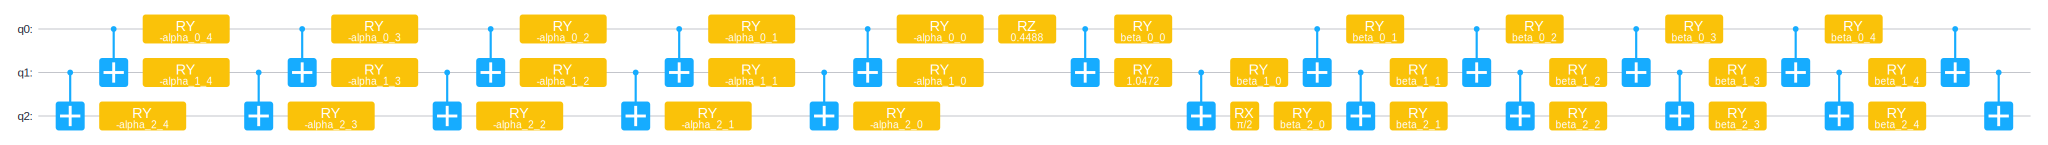

In [21]:
#Construct the quantum circuits for U^\dagger(alpha) M V(beta)
#This circuit is a linear sum of K circuits: U^\dagger(alpha) Ak V(beta)
from mindquantum.core.circuit import dagger
UhA0V_circ = dagger(U_circ) + A0_circ + V_circ
UhA1V_circ = dagger(U_circ) + A1_circ + V_circ
UhA2V_circ = dagger(U_circ) + A2_circ + V_circ

UhA0V_circ.svg()
#UhA1V_circ.svg()
#UhA2V_circ.svg()

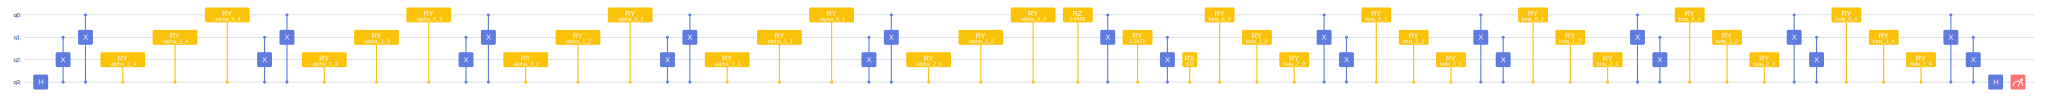

In [22]:
# construct the circuit for Hadamard test
from mindquantum.core.gates import H, Measure  # 引入测量门
from mindquantum.core.circuit import controlled

control0_H = controlled(UhA0V_circ)    
circ0_Hadamard = Circuit()                            # 初始化量子线路             
circ0_Hadamard = H.on(3) + control0_H(3) + H.on(3) + Measure('q0').on(3) # 在3号量子比特作用一个测量，并将该测量命名为'q0',对应A0

control1_H = controlled(UhA1V_circ)    
circ1_Hadamard = Circuit()                            # 初始化量子线路             
circ1_Hadamard = H.on(3) + control1_H(3) + H.on(3) + Measure('q1').on(3) # 在3号量子比特作用一个测量，并将该测量命名为'q1',,对应A1

control2_H = controlled(UhA2V_circ)    
circ2_Hadamard = Circuit()                            # 初始化量子线路             
circ2_Hadamard = H.on(3) + control2_H(3) + H.on(3) + Measure('q2').on(3) # 在3号量子比特作用一个测量，并将该测量命名为'q2',对应A2

circ0_Hadamard.svg()
#circ1_Hadamard.svg()
#circ2_Hadamard.svg()

In [23]:
#define a function to calculate the loss function and m_j
#sim: a quantum simulator
#circ0_Hadamard, circ1_Hadamard, circ2_Hadamard: the three circuits for Hadamard test
#pr_circ: parameters in the circuit
#n_shots: shots number 
#ck: M = \sum_k ck Ak 
#psi: basis 
#q_array: for calculating the loss function
#nM:dimension of M
def calculate_loss(sim,circ0_Hadamard, circ1_Hadamard, circ2_Hadamard, pr_circ, n_shots, ck, psi, q_array, nM): #calculate the Loss function
    #import numpy as np
    #import math
    #PI=math.pi
    m_array = np.full((nM, 1), 0, dtype = complex)
    for j in range(nM):
        state0 = np.tensordot(psi[j], [1,0],0) 
        state=[]
        for i in range(nM):
            state = np.append(state, state0[i,:])  #prepare the state
        
        sim.set_qs(state)  # set the state for the simulator
        #u_mat[j,:] = np.matmul(U_pr, psi[j])
        #v_mat[j,:] = np.matmul(V_pr, psi[j])
        result=sim.sampling(circ0_Hadamard, pr=pr_circ, shots=n_shots)
        m_array[j] = ck[0]*(result.data['0'] - result.data['1'])/n_shots
        sim.set_qs(state)  # set the state for the simulator
        result=sim.sampling(circ1_Hadamard, pr=pr_circ, shots=n_shots)
        m_array[j] = m_array[j] + ck[1]*(result.data['0'] - result.data['1'])/n_shots
        sim.set_qs(state)  # set the state for the simulator
        result=sim.sampling(circ2_Hadamard, pr=pr_circ, shots=n_shots)
        m_array[j] = m_array[j] + ck[2]*(result.data['0'] - result.data['1'])/n_shots

    LossF = np.matmul(q_array,m_array)
    return LossF, m_array #, u_mat, v_mat

In [25]:
from mindquantum import ParameterResolver
from mindquantum.simulator import Simulator    # 从mindquantum.simulator中导入Simulator类
sim = Simulator('mqvector', 4)    #claim a 4-qbit mqvector simulator
step = 0.02 #step for changing parameters in the circuit

error = 10 # initial error, should be > tol
n_shots=1000
nM=M.shape[1]
u_mat = np.full((nM, nM), 0, dtype = complex)  #initialize the U matrix
v_mat = np.full((nM, nM), 0, dtype = complex)  #initialize the V matrix
m_array = np.full((nM, 1), 0, dtype = complex) #initialize m_j
grad_alpha = np.full((N, Depth), 0, dtype = complex) #gradient wrt alpha
grad_beta = np.full((N, Depth), 0, dtype = complex)  #gradient wrt beta

alpha = alpha0
beta = beta0
n_max = 200      #max number for iteration
i_count = 0     #count the number of intertion
while error > tol:
    prU = ParameterResolver()
    prV= ParameterResolver()
    for i in range(N):
        for j in range(Depth):
            prU += ParameterResolver({f'alpha_{i}_{j}': alpha[i,j]}) #set the parameters in U circuit
            prV += ParameterResolver({f'beta_{i}_{j}': beta[i,j]}) #set the parameters in V circuit

    #U_pr = U_circ.matrix(prU)
    #V_pr = V_circ.matrix(prV)


    pr_UV = prU + prV #set the parameters in the Hadamard test circuit
    LossF, m_array = calculate_loss(sim,circ0_Hadamard, circ1_Hadamard, circ2_Hadamard, pr_UV, n_shots, ck, psi, q_array, nM)
    #calculate the gradient
    for i in range(N):
        for j in range(Depth):
            pr_UV2 = pr_UV + ParameterResolver({f'alpha_{i}_{j}': (alpha[i,j] + PI) })
            pr_UV3 = pr_UV + ParameterResolver({f'beta_{i}_{j}': (beta[i,j] - PI) })
            grad_alpha[i,j], m_array2 = calculate_loss(sim,circ0_Hadamard, circ1_Hadamard, circ2_Hadamard, pr_UV2, n_shots, ck, psi, q_array, nM)
            grad_beta[i,j], m_array3 = calculate_loss(sim,circ0_Hadamard, circ1_Hadamard, circ2_Hadamard, pr_UV3, n_shots, ck, psi, q_array, nM)
    
    grad_alpha = grad_alpha/2
    grad_beta = grad_beta/2
    alpha1 = alpha
    beta1 = beta
    alpha = alpha + step * grad_alpha
    beta = beta + step * grad_beta
    
    i_count += 1
    if i_count ==1:
        LossF0 = LossF
    elif i_count > n_max:
        error = abs((LossF-LossF0)/LossF0)
        print('WARNING: slow convergence for the loss function')
        print('error = ', error)
        break
    else:
        error = abs((LossF-LossF0)/LossF0)
        Loss0 = LossF
        
    if (i_count/1).is_integer():
        print('i_count=', i_count, ', LossF= ', LossF, ', error=', error)

alpha = alpha1
beta = beta1

i_count= 1 , LossF=  [5.71418544+0.j] , error= 10
i_count= 2 , LossF=  [1.20571207+0.j] , error= [0.78899669]
i_count= 3 , LossF=  [-0.15777801+0.j] , error= [1.02761164]
i_count= 4 , LossF=  [-2.2552072+0.j] , error= [1.39466819]
i_count= 5 , LossF=  [-0.83603308+0.j] , error= [1.14630836]
i_count= 6 , LossF=  [0.34045586+0.j] , error= [0.94041918]
i_count= 7 , LossF=  [1.90630561+0.j] , error= [0.66639066]
i_count= 8 , LossF=  [1.4656732+0.j] , error= [0.74350269]
i_count= 9 , LossF=  [1.05627549+0.j] , error= [0.81514855]
i_count= 10 , LossF=  [2.59260136+0.j] , error= [0.5462868]
i_count= 11 , LossF=  [0.45647189+0.j] , error= [0.92011602]
i_count= 12 , LossF=  [0.78295889+0.j] , error= [0.86297979]
i_count= 13 , LossF=  [1.52834703+0.j] , error= [0.73253458]
i_count= 14 , LossF=  [-0.54534997+0.j] , error= [1.09543792]
i_count= 15 , LossF=  [0.45012423+0.j] , error= [0.92122688]
i_count= 16 , LossF=  [-0.06978805+0.j] , error= [1.01221312]
i_count= 17 , LossF=  [-0.50887351+0.j] ,

In [22]:
print(T)

T


In [ ]:
#set the parameter in V circuit

### 9.输出$\{m_j\}_{j=1}^T$,对应矩阵$M$最大的$T$个奇异值，并且输出$U({\bf \alpha^*})$和$V({\bf \beta^*})$，得到左奇异矢为$(\langle \psi_j | U({\bf \alpha^*}))^{\dagger}$,右奇异矢为$V({\bf \beta^*}) | \psi_j \rangle$。


## References
X. Wang, Z. Song, Y. Wang, Variational Quantum Singular Value Decomposition, Quantum. 5 (2021) 483. https://doi.org/10.22331/q-2021-06-29-483.